In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# load dataset
df_AAPL = pd.read_csv('../datasets/AAPL.csv', header=0, index_col=0)
df_AAPL.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,47.84,47.99,47.55,47.81,"18,308,460"
6/12/2018,47.85,48.15,47.79,48.07,"16,911,141"
6/13/2018,48.11,48.22,47.61,47.68,"21,638,393"
6/14/2018,47.89,47.89,47.56,47.70,"21,610,074"
6/15/2018,47.51,47.54,47.07,47.21,"61,719,160"


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   object 
dtypes: float64(4), object(1)
memory usage: 59.0+ KB


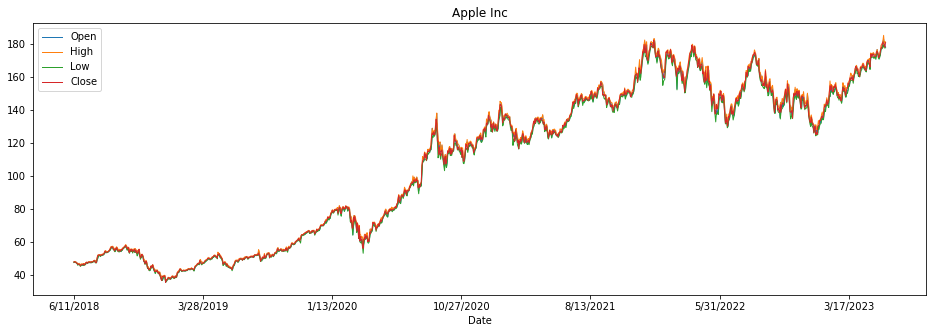

In [5]:
df_AAPL.info()
df_AAPL.plot(figsize=(16,5),lw=1, title="Apple Inc")
plt.show()

In [6]:
df_AAPL.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.00000,1258.000000
mean,107.870246,109.176582,106.65163,107.975223
std,45.929698,46.482485,45.40261,45.969246
min,35.990000,36.430000,35.50000,35.550000
25%,55.887500,56.492500,55.15750,55.945000
50%,121.720000,123.495000,120.20500,121.600000
75%,148.207500,149.745000,146.81750,148.480000
max,182.630000,184.950000,179.26000,182.010000


In [8]:
df_AAPL['Date'] = pd.to_datetime(df_AAPL.index)
print(f'Dataframe contains stock prices between {df_AAPL.Date.min()} {df_AAPL.Date.max()}')
print(f'Total days = {(df_AAPL.Date.max() - df_AAPL.Date.min()).days} days')

Dataframe contains stock prices between 2018-06-11 00:00:00 2023-06-08 00:00:00
Total days = 1823 days


In [10]:
df_close = df_AAPL['Close']
df_close.shape

(1258,)

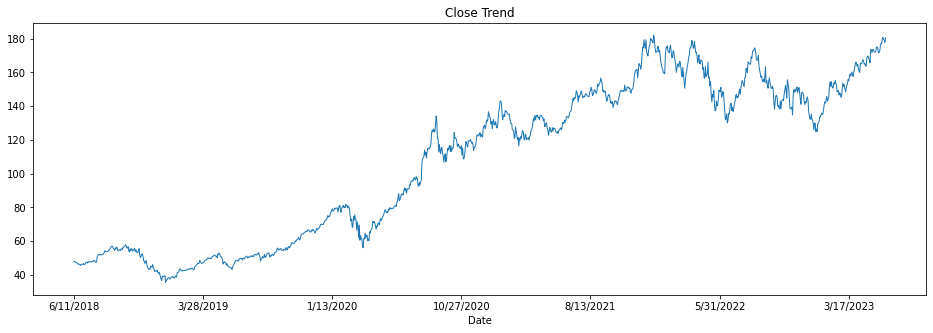

In [14]:
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [17]:
df_close.shape

(1258, 1)

In [21]:
df_close

array([[0.08370886],
       [0.08548409],
       [0.08282125],
       ...,
       [0.98088215],
       [0.97139151],
       [0.99016796]])

In [23]:
# Train Test split
training_size=int(len(df_close)*0.65)
test_size=len(df_close)-training_size
train_data, test_data=df_close[0:training_size,:],df_close[training_size:len(df_close),:1]

In [24]:
training_size, test_size

(817, 441)

In [29]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [30]:
# Reshape into X=t, t+1, t+2, t+3, and Y=t+4
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [35]:
print(f"X_train shape: {X_train.shape},\ny_train shape: {y_train.shape}")

X_train shape: (716, 100),
y_train shape: (716,)


In [37]:
print(f"X_test shape: {X_test.shape},\ny_test shape: {y_test.shape}")

X_test shape: (340, 100),
y_test shape: (340,)


In [38]:
# Reshape input to be samples, time steps, features which is required for LSTM
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [39]:
# Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [41]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 15s 452ms/step - loss: 0.0614 - val_loss: 0.0386
Epoch 2/100
12/12 [==============================] - 3s 277ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 3/100
12/12 [==============================] - 3s 280ms/step - loss: 0.0038 - val_loss: 0.0064
Epoch 4/100
12/12 [==============================] - 3s 292ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 5/100
12/12 [==============================] - 3s 262ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/100
12/12 [==============================] - 3s 257ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 7/100
12/12 [==============================] - 3s 269ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/100
12/12 [==============================] - 4s 335ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 9/100
12/12 [==============================] - 3s 267ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 10/100
12/12 [==============================] - 4s 297ms/step - loss: 0.0013 - val_l

12/12 [==============================] - 3s 242ms/step - loss: 5.1803e-04 - val_loss: 0.0011
Epoch 80/100
12/12 [==============================] - 3s 233ms/step - loss: 5.1560e-04 - val_loss: 0.0018
Epoch 81/100
12/12 [==============================] - 3s 265ms/step - loss: 5.0400e-04 - val_loss: 0.0013
Epoch 82/100
12/12 [==============================] - 3s 243ms/step - loss: 4.9792e-04 - val_loss: 0.0013
Epoch 83/100
12/12 [==============================] - 3s 242ms/step - loss: 4.7843e-04 - val_loss: 0.0011
Epoch 84/100
12/12 [==============================] - 3s 268ms/step - loss: 4.4322e-04 - val_loss: 0.0018
Epoch 85/100
12/12 [==============================] - 3s 241ms/step - loss: 4.7339e-04 - val_loss: 0.0011
Epoch 86/100
12/12 [==============================] - 3s 235ms/step - loss: 4.4645e-04 - val_loss: 0.0016
Epoch 87/100
12/12 [==============================] - 3s 240ms/step - loss: 4.7763e-04 - val_loss: 0.0015
Epoch 88/100
12/12 [==============================] - 3s 24

In [44]:
# Prediction and performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 1s 52ms/step


In [45]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

92.31807996916064

In [47]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

152.136472041515

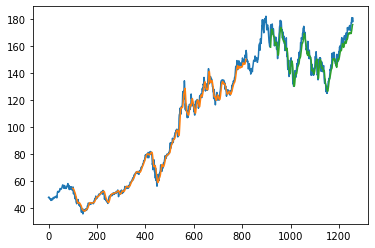

In [52]:
# Plotting
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [53]:
len(test_data)

441

In [55]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [56]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [57]:
# Demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while (i<30):
    if(len(temp_input)>100):
        # Print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1, n_steps, 1))
        # Print(x_input)
        yhat=model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        # Print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1, n_steps, 1))
        yhat=model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
print(lst_output)

[0.955591]
101
1 day input [0.68045883 0.6808685  0.69862078 0.72074286 0.73043834 0.72586372
 0.7402021  0.75365287 0.73364741 0.74245528 0.75023897 0.78704083
 0.81216714 0.79325413 0.81319132 0.79455141 0.78738222 0.78833811
 0.80772907 0.803291   0.81783422 0.80677318 0.79885293 0.77106377
 0.77399973 0.77734535 0.75897856 0.7672402  0.76375802 0.74941964
 0.75351632 0.78847467 0.80759252 0.79236652 0.80103783 0.78547044
 0.77120033 0.7846511  0.79912604 0.80185716 0.82138468 0.81558105
 0.83196777 0.84480404 0.83490373 0.84241431 0.85142701 0.83797624
 0.83367472 0.85497747 0.86583367 0.88317629 0.8918476  0.88816059
 0.8753926  0.88153762 0.8635805  0.8551823  0.85040284 0.88768264
 0.88529291 0.88542947 0.89389594 0.9018162  0.89512495 0.88399563
 0.88611225 0.87546088 0.8753926  0.90714188 0.91581319 0.91519869
 0.9080295  0.90058719 0.88925304 0.94237334 0.9418954  0.9300833
 0.94230507 0.94360235 0.93554554 0.93213164 0.93213164 0.93636488
 0.95247849 0.95322955 0.94667486 0.

8 day output [[0.88609517]]
9 day input [0.73364741 0.74245528 0.75023897 0.78704083 0.81216714 0.79325413
 0.81319132 0.79455141 0.78738222 0.78833811 0.80772907 0.803291
 0.81783422 0.80677318 0.79885293 0.77106377 0.77399973 0.77734535
 0.75897856 0.7672402  0.76375802 0.74941964 0.75351632 0.78847467
 0.80759252 0.79236652 0.80103783 0.78547044 0.77120033 0.7846511
 0.79912604 0.80185716 0.82138468 0.81558105 0.83196777 0.84480404
 0.83490373 0.84241431 0.85142701 0.83797624 0.83367472 0.85497747
 0.86583367 0.88317629 0.8918476  0.88816059 0.8753926  0.88153762
 0.8635805  0.8551823  0.85040284 0.88768264 0.88529291 0.88542947
 0.89389594 0.9018162  0.89512495 0.88399563 0.88611225 0.87546088
 0.8753926  0.90714188 0.91581319 0.91519869 0.9080295  0.90058719
 0.88925304 0.94237334 0.9418954  0.9300833  0.94230507 0.94360235
 0.93554554 0.93213164 0.93213164 0.93636488 0.95247849 0.95322955
 0.94667486 0.92864946 0.93056125 0.93841322 0.95507306 0.96784105
 0.96749966 0.98689062 0.

16 day output [[0.8408791]]
17 day input [0.78738222 0.78833811 0.80772907 0.803291   0.81783422 0.80677318
 0.79885293 0.77106377 0.77399973 0.77734535 0.75897856 0.7672402
 0.76375802 0.74941964 0.75351632 0.78847467 0.80759252 0.79236652
 0.80103783 0.78547044 0.77120033 0.7846511  0.79912604 0.80185716
 0.82138468 0.81558105 0.83196777 0.84480404 0.83490373 0.84241431
 0.85142701 0.83797624 0.83367472 0.85497747 0.86583367 0.88317629
 0.8918476  0.88816059 0.8753926  0.88153762 0.8635805  0.8551823
 0.85040284 0.88768264 0.88529291 0.88542947 0.89389594 0.9018162
 0.89512495 0.88399563 0.88611225 0.87546088 0.8753926  0.90714188
 0.91581319 0.91519869 0.9080295  0.90058719 0.88925304 0.94237334
 0.9418954  0.9300833  0.94230507 0.94360235 0.93554554 0.93213164
 0.93213164 0.93636488 0.95247849 0.95322955 0.94667486 0.92864946
 0.93056125 0.93841322 0.95507306 0.96784105 0.96749966 0.98689062
 0.99276253 0.98340844 0.98088215 0.97139151 0.99016796 0.95559102
 0.95013124 0.94174159 0

24 day output [[0.81250846]]
25 day input [0.77399973 0.77734535 0.75897856 0.7672402  0.76375802 0.74941964
 0.75351632 0.78847467 0.80759252 0.79236652 0.80103783 0.78547044
 0.77120033 0.7846511  0.79912604 0.80185716 0.82138468 0.81558105
 0.83196777 0.84480404 0.83490373 0.84241431 0.85142701 0.83797624
 0.83367472 0.85497747 0.86583367 0.88317629 0.8918476  0.88816059
 0.8753926  0.88153762 0.8635805  0.8551823  0.85040284 0.88768264
 0.88529291 0.88542947 0.89389594 0.9018162  0.89512495 0.88399563
 0.88611225 0.87546088 0.8753926  0.90714188 0.91581319 0.91519869
 0.9080295  0.90058719 0.88925304 0.94237334 0.9418954  0.9300833
 0.94230507 0.94360235 0.93554554 0.93213164 0.93213164 0.93636488
 0.95247849 0.95322955 0.94667486 0.92864946 0.93056125 0.93841322
 0.95507306 0.96784105 0.96749966 0.98689062 0.99276253 0.98340844
 0.98088215 0.97139151 0.99016796 0.95559102 0.95013124 0.94174159
 0.93206018 0.92207003 0.91228628 0.90296239 0.89421612 0.88609517
 0.87860781 0.8717368

In [58]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [59]:
len(df_close)

1258

In [60]:
df1=df_close.tolist()
df1.extend(lst_output)

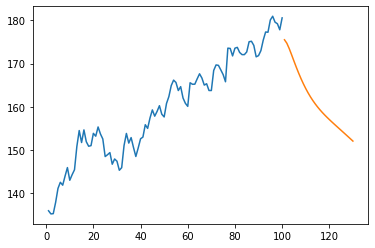

In [62]:
plt.plot(day_new,scaler.inverse_transform(df_close[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

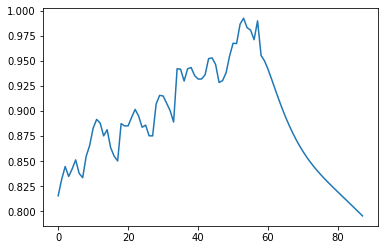

In [66]:
df2=df_close.tolist()
df2.extend(lst_output)
plt.plot(df2[1200:])